In [1]:
# this path append is for binder only
import sys
sys.path.append("../../")

#spectrome modules
# from spectrome.forward import runforward, runforward_spatialcorrelation_topalpha
from spectrome.utils import functions, path
from spectrome.brain import Brain
# from spectrome.stability import localstability_microintensity_allrois
from spectrome.stability import localstability
# from spectrome.forward import network_transfer_macrostable_microintensity_extrastimulus as nt
# from spectrome.forward import network_transfer_macrostable_microintensity as nt_nostimulus
from spectrome.forward import network_transfer_macrostable as nt

#generic modules
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import pickle as pkl
from scipy import stats
from scipy.stats import pearsonr
from scipy.io import loadmat
from sklearn.preprocessing import minmax_scale

pd.DataFrame.iteritems = pd.DataFrame.items

plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

In [32]:
data_dir = path.get_data_path()

# cortical areas with MEG collected + source reconstructed
rois_with_MEG = np.arange(0,68)

ind_psd_xr = xr.open_dataarray('../data/individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values

ind_conn_xr = xr.open_dataarray('../data/individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

ind_regions = ind_conn_xr["regionx"].values

fvec = ind_psd_xr["frequencies"].values

lpf = np.array([1, 2, 3, 2, 1])
lpf = lpf/np.sum(lpf)

# w_10I_ind_stableg_microint_highv = np.loadtxt("/data/rajlab1/user_data/parul/spectromeP_results/results_globalSGM/chang_tauiu200_stableg_macrostable_spatial_nodb/spectral_spatial_10weightedcorr_ind_allstable_microint.csv",delimiter=",")
# w_10I_ind_stableg_microint_highv = np.loadtxt("/data/rajlab1/user_data/parul/spectromeP_results/results_globalSGM/alpha_experiments/microint_receptors_gei_nogee_receptorscaled.csv",delimiter=",")
w_10I_ind_stableg_microint_highv = np.loadtxt("/data/rajlab1/user_data/parul/spectromeP_results/results_globalSGM/alpha_experiments/noreducedC_Cnormalized_mahalanobis/orgSGM_chang_micatemplate.csv",delimiter=",")


w_10I_ind_stableg_microint_highv_sorted = w_10I_ind_stableg_microint_highv[np.argsort(w_10I_ind_stableg_microint_highv[:,10])]

w_chosen = w_10I_ind_stableg_microint_highv_sorted

df_params=pd.DataFrame({'tau_e':w_chosen[:,0], 'tau_i':w_chosen[:,1], 'alpha':w_chosen[:,2], 'speed':w_chosen[:,3], 'gei':w_chosen[:,4], 'gii':w_chosen[:,5], 'tauC':w_chosen[:,6]})

ind_conn_regions = ind_conn_xr["regionx"].values

In [33]:
def run_local_coupling_forward(brain, params, freqs, stimulus_roi, w_var, w_means):

    eigenvalues = []
    eigenvectors = []
    frequency_response = []
    model_out = []
    

    for freq in freqs:
        w = 2 * np.pi * freq
        freq_model, freq_resp, eig_val, eig_vec = nt.network_transfer_local_alpha(
            brain, params, w, stimulus_roi, w_var, w_means
        )
        frequency_response.append(freq_resp)
        eigenvalues.append(eig_val)
        eigenvectors.append(eig_vec)
        model_out.append(freq_model)
       

    frequency_response = np.asarray(frequency_response)
    eigenvalues = np.asarray(eigenvalues)
    eigenvectors = np.asarray(eigenvectors)
    model_out = np.transpose(np.asarray(model_out))
   

    return model_out, frequency_response, eigenvalues, eigenvectors

def run_local_coupling_forward_Xk(brain, params, freqs, PSD, SC, rois_with_MEG, band, stimulus_roi, w_var, w_means):

    if band == "alpha":
        freqband = np.where((freqs>=8) & (freqs<=12))[0]
    if band == "beta":
        freqband = np.where((freqs>=13) & (freqs<=25))[0]

    eigvec_ns = np.zeros((len(rois_with_MEG),len(freqband)))

    for i in range(len(freqband)):
        w = 2 * np.pi * freqs[freqband[i]]
        eigenvectors_ns, _, _, _ = nt.network_transfer_local_alpha(
            brain, params, w, stimulus_roi, w_var, w_means
        )

        eigvec_ns[:,i] = eigenvectors_ns[rois_with_MEG]
        # eigvec_ns[:,i] = eigenvectors_ns

    eigvec_ns_summed = np.sum(eigvec_ns,axis = 1)

    # eigvec_summed = eigvec_ns_summed/np.linalg.norm(eigvec_ns_summed)

    summed_PSD = np.sum(PSD[:,freqband], axis = 1)

    # summed_PSD = summed_PSD/np.linalg.norm(summed_PSD)
    
    return summed_PSD, eigvec_ns_summed    

In [34]:
def getpsd(cdk,psd,rois_with_MEG,fvec,lpf,s,df_in, stimulus_roi, w_var, w_means):

    C_ind = cdk[:,:,s] # grab current subject's individual connectome
    F_ind = psd[:,:,s] # grab current subject's MEG

#     ex_template_xr = xr.open_dataarray('/data/rajlab1/shared_data/datasets/neurotransmitters/ex_template.nc')
#     ex_template = ex_template_xr.values
#     receptor_regions = ex_template_xr["regions"].values

#     ind_regions_notpresent = np.where(np.isin(ind_conn_regions, receptor_regions, invert=True))[0]
    
    # data_dir = path.get_data_path()
    # # create spectrome brain:
    brain = Brain.Brain()
    # brain.add_connectome(data_dir) # grabs distance matrix
    # # re-ordering for DK atlas and normalizing the connectomes:
    # brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    # brain.connectome = C_ind # re-assign connectome to individual connectome
    # brain.reducedConnectome = brain.connectome
    # # brain.connectome = SC_volnorm_template
    # brain.bi_symmetric_c()
    # brain.reduce_extreme_dir()
    sc_dk_mica = loadmat("/data/rajlab1/shared_data/datasets/MICA/mica_sc_dt_aparc_nocorpuscollusum.mat")

    conn = sc_dk_mica['SC_mean']
    dist = sc_dk_mica['DT_mean']

    # create spectrome brain:

    # brain = Brain.Brain()
    brain.connectome = conn
    brain.distance_matrix = dist
    brain.reorder_connectome_mica(brain.connectome, brain.distance_matrix)
    brain.reducedConnectome = brain.connectome
#     sc_dk_mica = loadmat("/data/rajlab1/shared_data/datasets/MICA/mica_sc_dt_aparc.mat")

#     conn = sc_dk_mica['SC_mean']
#     dist = sc_dk_mica['DT_mean']
#     brain.connectome = conn
#     brain.distance_matrix = dist
    # brain.reducedConnectome = conn
    # brain.bi_symmetric_c_mica()
    # brain.reduce_extreme_dir()
#     brain.distance_matrix = get_mean_C(brain.distance_matrix)
    # brain.connectome = np.delete(brain.connectome,ind_regions_notpresent,0)
    # brain.connectome = np.delete(brain.connectome,ind_regions_notpresent,1)
    # brain.reducedConnectome = np.delete(brain.reducedConnectome,ind_regions_notpresent,0)
    # brain.reducedConnectome = np.delete(brain.reducedConnectome,ind_regions_notpresent,1)
    # brain.distance_matrix = np.delete(brain.distance_matrix,ind_regions_notpresent,0)
    # brain.distance_matrix = np.delete(brain.distance_matrix,ind_regions_notpresent,1)

    brain.ntf_params["tau_e"] = df_in['tau_e'][s]/1000
    brain.ntf_params["tau_i"] = df_in['tau_i'][s]/1000
    # brain.ntf_params["tau_i"] = 200/1000
    brain.ntf_params["alpha"] = df_in['alpha'][s]
    brain.ntf_params["speed"] = df_in['speed'][s]
    brain.ntf_params["gei"] = df_in['gei'][s]
    brain.ntf_params["gii"] = df_in['gii'][s]
    brain.ntf_params["tauC"] = df_in['tauC'][s]/1000
    
#     brain.ntf_params["tau_i"] = 200/1000
    
#     if df_in['gei'][i] > 0.5:
#         brain.ntf_params["gei"] = 0.5
        
#     if df_in['gii'][i] > 1.5:
#         brain.ntf_params["gii"] = 1.5

    model_spectrum, _, _, _ = run_local_coupling_forward(brain, brain.ntf_params, fvec, stimulus_roi, w_var, w_means)

    model_spectrum = model_spectrum[rois_with_MEG,:]
    
    filfinal = 0

    for g in range(len(model_spectrum)):
        spectrum = np.abs(model_spectrum[g,:])        
        filtered = functions.mag2db(spectrum)
        filfinal += filtered

    filfinal = filfinal/len(model_spectrum)

    # Return average psd for a specific subject (old or new depending on choice)

    meg_spat, model_spat = run_local_coupling_forward_Xk(brain, brain.ntf_params, fvec, F_ind, 86, rois_with_MEG,"alpha", stimulus_roi, w_var, w_means)
    
    return filfinal, meg_spat, model_spat

In [35]:
# Find top most regions in alpha band

stimulus_roi = np.array([])

nsubs = len(w_chosen[:,0])
new_spectra = 0
new_spectra2 = 0
org_spectra_overall = 0
meg_spat_tot = 0
model_spat_tot = 0

w_var = 1
w_means = 0

model_spectra_stimulus = np.zeros((44,40))


for i in range(nsubs):
    
    spec_predicted, meg_spat, model_spat = getpsd(ind_conn,ind_psd,rois_with_MEG,fvec,lpf,i,df_params, stimulus_roi, w_var, w_means)
    new_spectra += spec_predicted/nsubs
    meg_spat_tot += meg_spat/nsubs
    model_spat_tot += model_spat/nsubs

    org_spectra = 0
    for g in rois_with_MEG:
        # spectrum = ind_psd[g,:,i]
        spectrum = functions.mag2db(ind_psd[g,:,i])
#         spectrum = (spectrum - np.mean(spectrum))/(np.std(spectrum))
        org_spectra += spectrum
    org_spectra = org_spectra/len(rois_with_MEG)

    org_spectra_overall += org_spectra/nsubs
    
model_spectra_stimulus[0,:] = new_spectra

    

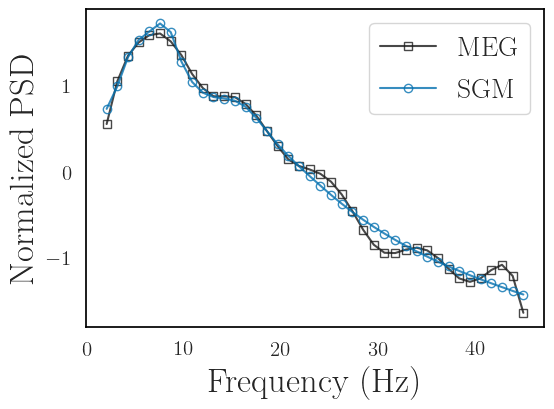

In [36]:
new_c = '#0571b0'

new_normalized = (new_spectra - np.mean(new_spectra))/(np.std(new_spectra))
org_normalized = (org_spectra_overall - np.mean(org_spectra_overall))/(np.std(org_spectra_overall))

colorp = sns.color_palette("colorblind",n_colors=3)

fig, ax = plt.subplots()


ax.plot(fvec,org_normalized,linestyle = '-',marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
ax.plot(fvec,new_normalized,linestyle = '-',marker = 'o',fillstyle = 'none',color = new_c, label = "SGM", alpha = 0.8)

ax.legend(fontsize = 20)
ax.set_xlabel('Frequency (Hz)', fontsize = 25)
ax.set_ylabel('Normalized PSD', fontsize = 25)

plt.tight_layout()


In [7]:
# import importlib
# importlib.reload(nt)

In [37]:
# filename = f'/data/rajlab1/user_data/parul/spectrome-spatial_results/results/spatial/noreducedC_Cnormalized_mahalanobis/alpha_all36subs_model_mica.p'
# with open(filename, 'wb') as f:
#     pkl.dump(model_spat_tot, f) 

# filename = f'/data/rajlab1/user_data/parul/spectrome-spatial_results/results/spatial/alpha_all36subs_meg_2.p'
# with open(filename, 'wb') as f:
#     pkl.dump(meg_spat_tot, f) 

# filename = f'/data/rajlab1/user_data/parul/spectrome-spatial_results/results/spatial/params/taui_upper_noreducedC_hcp_allstable.p'
# with open(filename, 'wb') as f:
#     pkl.dump(model_spat_tot, f) 

In [38]:
# Check stability
mica_micro_intensity = np.squeeze(loadmat('/data/rajlab1/shared_data/datasets/MICA/micro_intensity_mean.mat')['micro_intensity_mean'])
# Load excitatory profile
ex_template_xr = xr.open_dataarray('/data/rajlab1/shared_data/datasets/neurotransmitters/ex_template.nc')
ex_template = ex_template_xr.values
# Load inhibtory profile
inh_template_xr = xr.open_dataarray('/data/rajlab1/shared_data/datasets/neurotransmitters/inh_template.nc')
inh_template = inh_template_xr.values

st_all = []
brain = Brain.Brain()

for i in range(nsubs):
    brain.ntf_params["tau_e"] = df_params['tau_e'][i]
    brain.ntf_params["tau_i"] = df_params['tau_i'][i]
    brain.ntf_params["gei"] = df_params['gei'][i]
    brain.ntf_params["gii"] = df_params['gii'][i]
#     brain.ntf_params["tau_i"] = 200
    
#     if df_params['gei'][i] > 0.5:
#         brain.ntf_params["gei"] = 0.5
        
#     if df_params['gii'][i] > 1.5:
#         brain.ntf_params["gii"] = 1.5

        
    # st = localstability_microint_receptors_allrois.local_stability(brain.ntf_params,mica_micro_intensity,ex_template,inh_template)
    st = localstability.local_stability(brain.ntf_params,mica_micro_intensity)
    st_all.append(st)

In [39]:
ind_unstable = np.where(np.array(st_all)>0)
print(ind_unstable)
# print(np.array(df_params['gei'].tolist())[ind_unstable])
# print(np.array(df_params['gii'].tolist())[ind_unstable])

(array([], dtype=int64),)


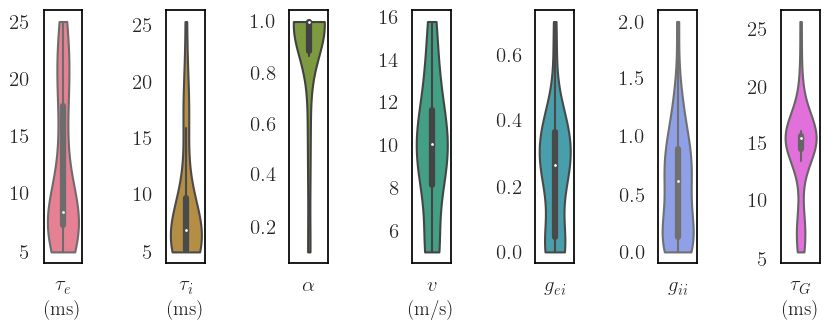

In [40]:
df=pd.DataFrame({r'$\tau_e$':w_chosen[:,0], r'$\tau_i$':w_chosen[:,1], r'$\alpha$':w_chosen[:,2], r'$v$':w_chosen[:,3], r'$g_{ei}$':w_chosen[:,4], r'$g_{ii}$':w_chosen[:,5], r'$\tau_G$':w_chosen[:,6]})

palette = sns.husl_palette(7) 

fig, ax = plt.subplots(1,7, num=1,  gridspec_kw={'width_ratios':[2,2,2,2,2,2,2]}, figsize=(9, 4))

sns.violinplot(data=df[[r'$\tau_e$']], ax=ax[0],color=palette[0],cut=0)
ax[0].set_xlabel('(ms)',fontsize=14)
sns.violinplot(data=df[[r'$\tau_i$']], ax=ax[1],color=palette[1],cut=0)
ax[1].set_xlabel('(ms)',fontsize=14)
sns.violinplot(data=df[[r'$\alpha$']], ax=ax[2],color=palette[2],cut=0)
sns.violinplot(data=df[[r'$v$']], ax=ax[3],color=palette[3],cut=0)
ax[3].set_xlabel('(m/s)',fontsize=14)
sns.violinplot(data=df[[r'$g_{ei}$']], ax=ax[4],color=palette[4],cut=0)
sns.violinplot(data=df[[r'$g_{ii}$']], ax=ax[5],color=palette[5],cut=0)
sns.violinplot(data=df[[r'$\tau_G$']], ax=ax[6],color=palette[6],cut=0)
ax[6].set_xlabel('(ms)',fontsize=14)
plt.tight_layout()


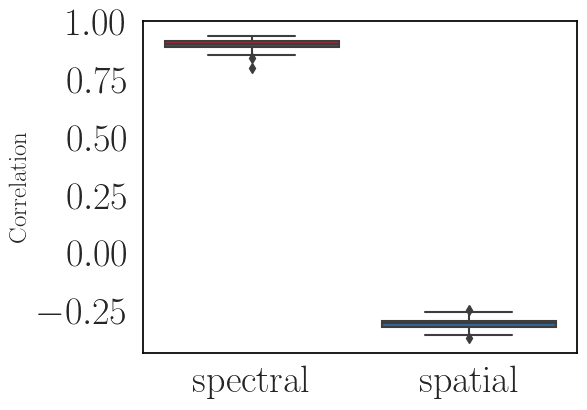

In [41]:
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_style("white")

col_ad = "#b2182b"
col_cont = "#2166ac"

my_colors = ["#b2182b", "#2166ac", 
             "#b2182b", "#2166ac"]

sns.set_palette( my_colors )

sns.set(font_scale=1.5, rc={'text.usetex' : True})
sns.set(font_scale=2.5, rc={'text.usetex' : True, 'figure.facecolor': 'white', 
                            'axes.facecolor': 'white', 'axes.edgecolor': 'black',
                           'font.family':'serif', 'font.serif':'Times New Roman'})

fig, ax = plt.subplots()

plt.rcParams.update({
    "xtick.labelsize": 15,
    "ytick.labelsize": 15
})


df_correlations = pd.DataFrame({'spectral': w_chosen[:,8],
                               'spatial': w_chosen[:,9]})


ax = sns.boxplot(data=df_correlations, ax=ax, palette=my_colors)

max_width = 8
ax.set_ylabel('Correlation', fontsize=18)
# ax.set_ylim([0.5,1.0])
# ax.set_yticks([0.5,0.6,0.7,0.8,0.9,1.0])

plt.tight_layout()

In [13]:
np.mean(w_chosen[:,9])

0.07395670917710909

In [8]:
mica_micro_intensity = np.squeeze(loadmat('/data/rajlab1/shared_data/datasets/MICA/micro_intensity_mean.mat')['micro_intensity_mean'])

In [9]:
np.amax(mica_micro_intensity)

1.09498868450775

In [10]:
np.amin(mica_micro_intensity)

0.9070790795823469

In [9]:
ex_template_xr = xr.open_dataarray('/data/rajlab1/shared_data/datasets/neurotransmitters/ex_template.nc')
ex_template = ex_template_xr.values

In [10]:
np.amax(ex_template)

1.1901310550997841

In [11]:
np.amin(ex_template)

0.761029438870883

In [12]:
inh_template_xr = xr.open_dataarray('/data/rajlab1/shared_data/datasets/neurotransmitters/inh_template.nc')
inh_template = inh_template_xr.values

In [13]:
np.amax(inh_template)

1.4789128669317109

In [14]:
np.amin(inh_template)

0.4630971416795897

In [15]:
len(inh_template)

82

In [16]:
lobes = pd.read_excel("/data/rajlab1/shared_data/datasets/RSN/DK_lobes.xlsx",header=None)

In [17]:
lobes[1][10]

'Frontal'

In [18]:
a = 0.9 
b = 1.1

mine = np.amin(ex_template)
maxe = np.amax(ex_template);

ex_template_scaled = np.zeros(ex_template.shape)

for i in range(len(ex_template)):
    ex_template_scaled[i] = (b-a)*(ex_template[i]-mine)/(maxe-mine) + a

mine = np.amin(inh_template)
maxe = np.amax(inh_template);

inh_template_scaled = np.zeros(inh_template.shape)

for i in range(len(inh_template)):
    inh_template_scaled[i] = (b-a)*(inh_template[i]-mine)/(maxe-mine) + a